<a href="https://colab.research.google.com/github/al-025/atlas-open-data/blob/main/Everything_Open_ATLAS_Open_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#install required packages
import sys
!pip install --upgrade --user pip
!pip install -U numpy==2.0.0 pandas==2.2.2 uproot==5.3.9 matplotlib==3.9.0 lmfit==1.3.1 awkward-pandas==2023.8.0 aiohttp==3.9.5 requests==2.32.3 vector --user


In [2]:
import uproot # for reading .root files
import time # to measure time to analyse
import math # for mathematical functions such as square root
import awkward as ak # for handling complex and nested data structures efficiently
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
import vector #to use vectors
import requests # for HTTP access
import aiohttp # HTTP client support
import pandas as pd # convenient data structure
from itertools import chain # for quickly flattening pandas dataframe columns

In [3]:
# ATLAS Open Data directory
path = "https://atlas-opendata.web.cern.ch/atlas-opendata/13TeV/GamGam/Data/" # web address

samples_list = [
    'data15_periodD','data15_periodE','data15_periodF','data15_periodG','data15_periodH','data15_periodJ',
    'data16_periodA','data16_periodB','data16_periodC','data16_periodD','data16_periodE','data16_periodF','data16_periodG','data16_periodK','data16_periodL'
]

In [4]:
data_15G_path = path + samples_list[3] + ".root"

# Accessing the file from the online database (":analysis" opens the tree in a desired manner)
with uproot.open(data_15G_path + ":analysis") as t:
	tree = t

# The number of entries in the tree can be viewed
print("The number of entries in the tree are:", tree.num_entries)

# All the information stored in the tree can be viewed using the .keys() method.
print("The information stored in the tree is:", tree.keys())

# For ease of access, we can import the data into a Pandas DataFrame
df = tree.arrays(library='pd')

The number of entries in the tree are: 164583
The information stored in the tree is: ['num_events', 'sum_of_weights', 'sum_of_weights_squared', 'corrected_xsec', 'dsid', 'category', 'sig_ph', 'n_sig_ph', 'ScaleFactor_PILEUP', 'mcWeight', 'xsec', 'filteff', 'kfac', 'channelNumber', 'eventNumber', 'runNumber', 'trigP', 'trigDT', 'trigT', 'trigE', 'trigM', 'trigMET', 'ScaleFactor_BTAG', 'jet_n', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_btag_quantile', 'jet_jvt', 'largeRJet_n', 'largeRJet_pt', 'largeRJet_eta', 'largeRJet_phi', 'largeRJet_e', 'largeRJet_m', 'largeRJet_D2', 'ScaleFactor_ELE', 'ScaleFactor_MUON', 'scaleFactor_LepTRIGGER', 'lep_n', 'lep_type', 'lep_pt', 'lep_eta', 'lep_phi', 'lep_e', 'lep_charge', 'lep_ptvarcone30', 'lep_topoetcone20', 'lep_z0', 'lep_d0', 'lep_d0sig', 'lep_isTightID', 'lep_isMediumID', 'lep_isLooseID', 'lep_isTightIso', 'lep_isLooseIso', 'ScaleFactor_PHOTON', 'photon_n', 'photon_pt', 'photon_eta', 'photon_phi', 'photon_e', 'photon_ptcone20', 'photon_topoe

In [5]:
# Grab a variable from the dataframe by indexing into df with that variable name:
df['met']

,met
0,21.719009
1,151.520767
2,25.950762
3,16.840445
4,20.721956
...,...
164578,46.942570
164579,22.520350
164580,10.728749
164581,47.988262


In [6]:
def make_hist(x,bin_size,xmin=None,xmax=None,xlabel='',ylabel='Events'):
  xmin = xmin or np.min(x)
  xmax = xmax or np.max(x)
  bin_edges = np.arange(start=xmin, # The interval includes this value
                    	stop=xmax+bin_size, # The interval doesn't include this value
                    	step=bin_size ) # Spacing between values
  bin_centres = np.arange(start=xmin+bin_size/2, # The interval includes this value
                      	stop=xmax+bin_size/2, # The interval doesn't include this value
                      	step=bin_size ) # Spacing between values

  data_x,_ = np.histogram(x,
                      	bins=bin_edges ) # histogram the data
  data_x_errors = np.sqrt(data_x)

  # *************
  # Main plot
  # *************
  main_axes = plt.gca() # get current axes

  # plot the data points
  main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                  	fmt='ko', # 'k' means black and 'o' is for circles
                  	label='Data')

  # set the x-limit of the main axes
  main_axes.set_xlim( left=xmin, right=xmax )

  # separation of x axis minor ticks
  main_axes.xaxis.set_minor_locator( AutoMinorLocator() )

  # set the axis tick parameters for the main axes
  main_axes.tick_params(which='both', # ticks on both x and y axes
                      	direction='in', # Put ticks inside and outside the axes
                      	top=True, # draw ticks on the top axis
                      	right=True ) # draw ticks on right axis

  # x-axis label
  main_axes.set_xlabel(xlabel,
                  	fontsize=13, x=1, horizontalalignment='right' )

  # write y-axis label for main axes
  main_axes.set_ylabel(ylabel,
                      	y=1, horizontalalignment='right')

  # set y-axis limits for main axes
  main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

  # add minor ticks on y-axis for main axes
  main_axes.yaxis.set_minor_locator( AutoMinorLocator() )

  # draw the legend
  main_axes.legend( frameon=False ); # no box around the legend

# convenient function for quickly flattening a column from a dataframe
def flatten_col(col):
  return pd.Series(list(chain.from_iterable(col)))

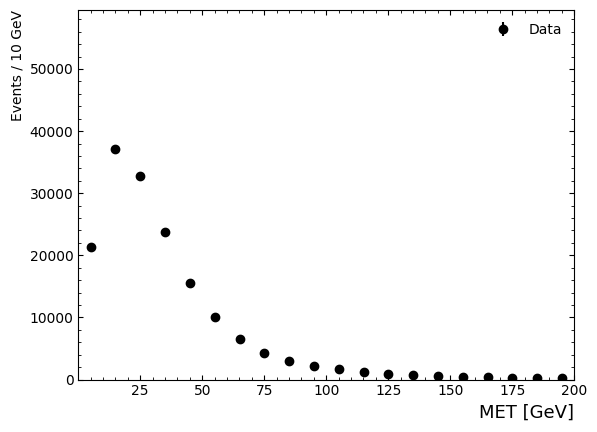

In [7]:
# To make a histogram of a variable, simply pass it into the make_hist function together with the desired binnings and axis labels, eg:
make_hist(df['met'], bin_size=10, xmin=0, xmax=200,
          xlabel='MET [GeV]', ylabel='Events / 10 GeV')

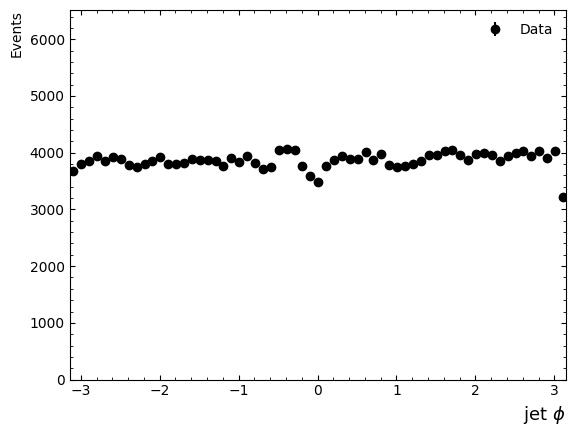

In [8]:
# Note that some variables have multiple values per event (one for each corresponding object present) - these need to be flattened prior to histogramming, eg:
make_hist(flatten_col(df['jet_phi']), bin_size=0.1, xlabel='jet $\phi$')

In [9]:
# Try making histograms for some other variables here, eg lep_pt or photon_e




---

# Recreating the Higgs Boson discovery plot

In [10]:
def result_plot(df, bin_size=3, xmin=100, xmax=160, fraction=1):
  bin_edges = np.arange(start=xmin, # The interval includes this value
                      stop=xmax+bin_size, # The interval doesn't include this value
                      step=bin_size ) # Spacing between values
  bin_centres = np.arange(start=xmin+bin_size/2, # The interval includes this value
                        stop=xmax+bin_size/2, # The interval doesn't include this value
                        step=bin_size ) # Spacing between values

  data_x,_ = np.histogram(ak.to_numpy(df['mass']),
                              bins=bin_edges ) # histogram the data
  data_x_errors = np.sqrt( data_x ) # statistical error on the data

  # data fit
  polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
  gaussian_mod = GaussianModel() # Gaussian

  # set initial guesses for the parameters of the polynomial model
  # c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
  pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                              x=bin_centres, c0=data_x.max(), c1=0,
                              c2=0, c3=0, c4=0 )

  # set initial guesses for the parameters of the Gaussian model
  pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                          x=bin_centres, amplitude=100,
                          center=125, sigma=2 )

  model = polynomial_mod + gaussian_mod # combined model

  # fit the model to the data
  out = model.fit(data_x, # data to be fit
                  pars, # guesses for the parameters
                  x=bin_centres, weights=1/data_x_errors ) #ASK

  # background part of fit
  params_dict = out.params.valuesdict() # get the parameters from the fit to data
  c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
  c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
  c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
  c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
  c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4

  # get the background only part of the fit to data
  background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

  # data fit - background fit = signal fit
  signal_x = data_x - background

  # *************
  # Main plot
  # *************
  plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height
  main_axes = plt.gca() # get current axes

  # plot the data points
  main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                  fmt='ko', # 'k' means black and 'o' means circles
                  label='Data' )

  # plot the signal + background fit
  main_axes.plot(bin_centres, # x
              out.best_fit, # y
              '-r', # single red line
              label='Sig+Bkg Fit ($m_H=125$ GeV)' )

  # plot the background only fit
  main_axes.plot(bin_centres, # x
              background, # y
              '--r', # dashed red line
              label='Bkg (4th order polynomial)' )

  # set the x-limit of the main axes
  main_axes.set_xlim( left=xmin, right=xmax )

  # separation of x-axis minor ticks
  main_axes.xaxis.set_minor_locator( AutoMinorLocator() )

  # set the axis tick parameters for the main axes
  main_axes.tick_params(which='both', # ticks on both x and y axes
                      direction='in', # Put ticks inside and outside the axes
                      top=True, # draw ticks on the top axis
                      labelbottom=False, # don't draw tick labels on bottom axis
                      right=True ) # draw ticks on right axis

  # write y-axis label for main
  main_axes.set_ylabel('Events / '+str(bin_size)+' GeV',
                      horizontalalignment='right')

  # set the y-axis limit for the main axes
  main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.1 )

  # set minor ticks on the y-axis of the main axes
  main_axes.yaxis.set_minor_locator( AutoMinorLocator() )

  # avoid displaying y=0 on the main axes
  main_axes.yaxis.get_major_ticks()[0].set_visible(False)

  # Add text 'ATLAS Open Data' on plot
  plt.text(0.2, # x
          0.92, # y
          'ATLAS Open Data', # text
          transform=main_axes.transAxes, # coordinate system used is that of main_axes
          fontsize=13 )

  # Add text 'for education' on plot
  plt.text(0.2, # x
          0.86, # y
          'for education', # text
          transform=main_axes.transAxes, # coordinate system used is that of main_axes
          style='italic',
          fontsize=8 )

  lumi = 36.1
  lumi_used = str(lumi*fraction) # luminosity to write on the plot
  plt.text(0.2, # x
          0.8, # y
          '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
          transform=main_axes.transAxes ) # coordinate system used is that of main_axes

  # Add a label for the analysis carried out
  plt.text(0.2, # x
          0.74, # y
          r'$H \rightarrow \gamma\gamma$', # text
          transform=main_axes.transAxes ) # coordinate system used is that of main_axes

  # draw the legend
  main_axes.legend(frameon=False, # no box around the legend
                  loc='lower left' ) # legend location


  # *************
  # Data-Bkg plot
  # *************
  plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
  sub_axes = plt.gca() # get the current axes

  # set the y axis to be symmetric about Data-Background=0
  sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto',
                                              symmetric=True) )

  # plot Data-Background
  sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                  fmt='ko' ) # 'k' means black and 'o' means circles

  # draw the fit to data
  sub_axes.plot(bin_centres, # x
              out.best_fit-background, # y
              '-r' ) # single red line

  # draw the background only fit
  sub_axes.plot(bin_centres, # x
              background-background, # y
              '--r' )  # dashed red line

  # set the x-axis limits on the sub axes
  sub_axes.set_xlim( left=xmin, right=xmax )

  # separation of x-axis minor ticks
  sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )

  # x-axis label
  sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                      x=1, horizontalalignment='right',
                      fontsize=13 )

  # set the tick parameters for the sub axes
  sub_axes.tick_params(which='both', # ticks on both x and y axes
                      direction='in', # Put ticks inside and outside the axes
                      top=True, # draw ticks on the top axis
                      right=True ) # draw ticks on right axis

  # separation of y-axis minor ticks
  sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )

  # y-axis label on the sub axes
  sub_axes.set_ylabel( 'Events-Bkg' )


  # Generic features for both plots
  main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
  sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

# This function calculates the invariant mass of the 2-photon state
def calc_mass(photon_pt, photon_eta, photon_phi, photon_e):
    p4 = vector.zip({"pt": photon_pt, "eta": photon_eta, "phi": photon_phi, "e": photon_e})
    invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
    return invariant_mass


In [11]:
# Here we cumulate data from all periods to get better statistics

variables = ["photon_pt","photon_eta","photon_phi","photon_e",
             "photon_isTightID","photon_ptcone20"]

all_data = []

# Loop over each file
for val in samples_list:

    # Print which sample is being processed
    print('Processing '+val+' samples')

    fileString = path + val + ".root" # file name to open

    # Open file
    with uproot.open(fileString + ":analysis") as t:
        tree = t

    numevents = tree.num_entries

    # Calculate the invariant mass and add it into the data structure
    for data in tree.iterate(variables, library="ak", entry_stop=numevents*1):
        data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])

        # Append data to the whole sample data list
        all_data.append(data)

# Convert back to DataFrame
all_data = ak.to_dataframe(ak.concatenate(all_data))

Processing data15_periodD samples
Processing data15_periodE samples
Processing data15_periodF samples
Processing data15_periodG samples
Processing data15_periodH samples
Processing data15_periodJ samples
Processing data16_periodA samples
Processing data16_periodB samples
Processing data16_periodC samples
Processing data16_periodD samples
Processing data16_periodE samples
Processing data16_periodF samples
Processing data16_periodG samples
Processing data16_periodK samples
Processing data16_periodL samples


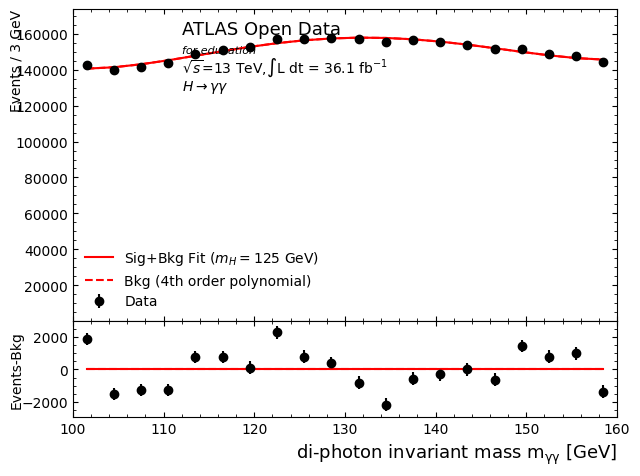

In [12]:
# Let's create the final result plot without making any selections on the data and see how it looks
result_plot(all_data)

In [13]:
# Need to apply some selections so that we can see the signal 'bump' over the background

# Cut on the photon reconstruction quality
def cut_photon_reconstruction(photon_isTightID):
    # Only the events which have True for both photons are kept
    return (photon_isTightID[:,0]==True) & (photon_isTightID[:,1]==True)

# Cut on the transverse momentum
def cut_photon_pt(photon_pt):
   # Only the events where photon_pt[0] > 40 GeV and photon_pt[1] > 30 GeV are kept
    return (photon_pt[:,0] > 40) & (photon_pt[:,1] > 30)

# Cut on the energy isolation
def cut_isolation_pt(photon_ptcone20):
    # Only the events where the isolation transverse energy is less than 4 GeV are kept
    return (photon_ptcone20[:,0] < 4) & (photon_ptcone20[:,1] < 4)

# Cut on the pseudorapidity in barrel/end-cap transition region
def cut_photon_eta_transition(photon_eta):
    # Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
    abs_eta = np.abs(photon_eta)
    condition_0 = (abs_eta[:, 0] < 1.37) | (abs_eta[:, 0] > 1.52)
    condition_1 = (abs_eta[:, 1] < 1.37) | (abs_eta[:, 1] > 1.52)
    return condition_0 & condition_1


In [14]:
# Now reduce our dataset using these cuts by indexing all_data with these conditions
selected_data = all_data
print('Initial events:',len(selected_data))

selected_data = all_data[ cut_photon_reconstruction(all_data['photon_isTightID']).reindex(selected_data.index,level='entry') ]
print('After reconstruction cut:',len(selected_data))

selected_data = selected_data[ cut_photon_pt(selected_data['photon_pt']).reindex(selected_data.index,level='entry') ]
print('After pt cut:',len(selected_data))

selected_data = selected_data[ cut_isolation_pt(selected_data['photon_ptcone20']).reindex(selected_data.index,level='entry') ]
print('After isolation cut:',len(selected_data))

selected_data = selected_data[ cut_photon_eta_transition(selected_data['photon_eta']).reindex(selected_data.index,level='entry') ]
print('After eta cut:',len(selected_data))


Initial events: 18541464
After reconstruction cut: 1655680
After pt cut: 879402
After isolation cut: 528299
After eta cut: 525342


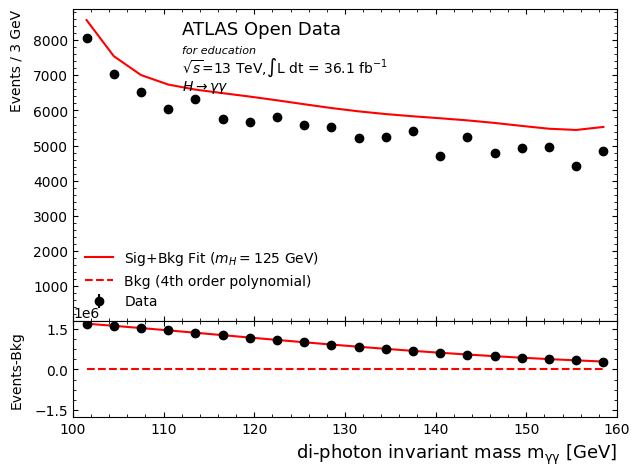

In [15]:
result_plot(selected_data)

In [16]:
# Controls the fraction of all the events analysed
fraction = 1 # all of the data is used to run this analysis (implemented in the loop over the tree)
             # reduce this if you want the code to run quicker

test_data = []
sample_data = []

# Loop over each file
for val in samples_list:

    # Print which sample is being processed
    print('Processing '+val+' samples')

    fileString = path + val + ".root" # file name to open

    # Open file
    with uproot.open(fileString + ":analysis") as t:
        tree = t

    numevents = tree.num_entries

    # Perform the cuts for each data entry in the tree and calculate the invariant mass
    for data in tree.iterate(variables, library="ak", entry_stop=numevents*fraction):

        photon_isTightID = data['photon_isTightID']
        data = data[cut_photon_reconstruction(photon_isTightID)]

        photon_pt = data['photon_pt']
        data = data[cut_photon_pt(photon_pt)]

        photon_ptcone20 = data['photon_ptcone20']
        data = data[cut_isolation_pt(photon_ptcone20)]

        photon_eta = data['photon_eta']
        data = data[cut_photon_eta_transition(photon_eta)]

        data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])

        # Append data to the whole sample data list
        sample_data.append(data)

# turns sample_data back into an awkward array
test_data = ak.concatenate(sample_data)

Processing data15_periodD samples
Processing data15_periodE samples
Processing data15_periodF samples
Processing data15_periodG samples
Processing data15_periodH samples
Processing data15_periodJ samples
Processing data16_periodA samples
Processing data16_periodB samples
Processing data16_periodC samples
Processing data16_periodD samples
Processing data16_periodE samples
Processing data16_periodF samples
Processing data16_periodG samples
Processing data16_periodK samples
Processing data16_periodL samples


In [17]:
len(test_data)

133610

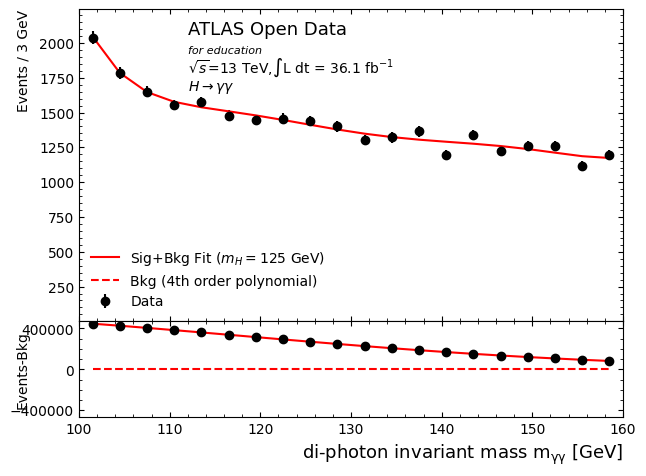

In [18]:
result_plot(test_data)